# SMDP_IOQL

In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
from tqdm import tqdm
import random
import gym
from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different. 
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
import gym
env = gym.make('Taxi-v3')

#env.seed(0)

state_shape = env.observation_space
no_of_actions = env.action_space.n

print("State shape:", state_shape)
print("Number of Actions: ",no_of_actions)
print("Sampled Action",env.action_space.sample())
print("----"*20)

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''
Passenger_locations = {0:"R(ed)",1:"G(reen)",2:"Y(ellow)",3:"B(lue)",4:"in taxi"}
Destinations = {0:"R(ed)",1:"G(reen)",2:"Y(ellow)",3:"B(lue)"}
Actions = {0: "move south", 1: "move north", 2: "move east", 3: "move west", 4: "pickup passenger",5: "drop off passenger"}
print("Actions: ",Actions)
print("Passenger_locations: ",Passenger_locations)
print("Destinations: ",Destinations)
print("----"*20)
state = env.reset()
''' This returns the initial state (when environment is reset) '''

print("Current_State: ",state)
print("Decoded Current_State [taxi_row, taxi_col, passenger_location, destination]: ",list(env.decode(state)))
print(env.render())
print("----"*20)

action = env.action_space.sample()
''' We take a random action now '''

print("Sampled Action: ", action)
print("----"*20)

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print("Next_State: ",next_state)
print("Decoded Next_State [taxi_row, taxi_col, passenger_location, destination]: ",list(env.decode(next_state)))
print("Reward: ",reward)
print("Done: ", done)
print("Info: ", info)
print("----"*20)

print(env.render())
print("----"*20)

State shape: Discrete(500)
Number of Actions:  6
Sampled Action 0
--------------------------------------------------------------------------------
Actions:  {0: 'move south', 1: 'move north', 2: 'move east', 3: 'move west', 4: 'pickup passenger', 5: 'drop off passenger'}
Passenger_locations:  {0: 'R(ed)', 1: 'G(reen)', 2: 'Y(ellow)', 3: 'B(lue)', 4: 'in taxi'}
Destinations:  {0: 'R(ed)', 1: 'G(reen)', 2: 'Y(ellow)', 3: 'B(lue)'}
--------------------------------------------------------------------------------
Current_State:  489
Decoded Current_State [taxi_row, taxi_col, passenger_location, destination]:  [4, 4, 2, 1]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

None
--------------------------------------------------------------------------------
Sampled Action:  2
--------------------------------------------------------------------------------
Next_State:  489
Decoded Next_State [taxi_row, taxi_col, passenger_location, destination]:  [4, 4, 2, 1]

In [3]:
env.nS,env.nA

(500, 6)

State = ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

## Actions and Options
##### Actions: There are 6 discrete deterministic actions: 0: move south; 1: move north; 2: move east; 3: move west; 4: pick passenger up; and 5: drop passenger off.
##### Options: Options to move the taxi to each of the four designated locations, executable when the taxi is not already there. i.e [move_to_11,move_to_12]


In [4]:
    
'''
Now the new action space will contain
Primitive Actions: ["up", "right", "down", "left", "pickup", "drop off"]
Options: ["move_to_R","move_to_G","move_to_Y","move_to_B"]
Total Actions :["up", "right", "down", "left", "pickup", "drop off", "move_to_R","move_to_G","move_to_Y","move_to_B"]
Corresponding to [0,1,2,3,4,5,6,7,8,9]
'''
policy_11 = np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [2, 0, 3, 3, 3], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])
policy_12 = np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [2, 2, 0, 3, 3], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])

Options_Policy = np.array([policy_11, policy_12])

In [5]:
def plot_policy(policy,message = "Policy plot"):
        DOWN = 0
        UP = 1
        LEFT = 3
        RIGHT = 2

        plt.title(message,fontsize=18)
        plt.pcolor(policy, edgecolors='k', linewidths=2) #,cmap="rainbow"
        plt.colorbar()
        def x_direct(a):
            if a in [UP, DOWN]:
                return 0
            return 1 if a == RIGHT else -1
        def y_direct(a):
            if a in [RIGHT, LEFT]:
                return 0
            return 1 if a == UP else -1
        policyx = np.vectorize(x_direct)(policy)
        policyy = np.vectorize(y_direct)(policy)
        idx = np.indices(policy.shape)
        plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax = plt.gca()
        ax.invert_yaxis()

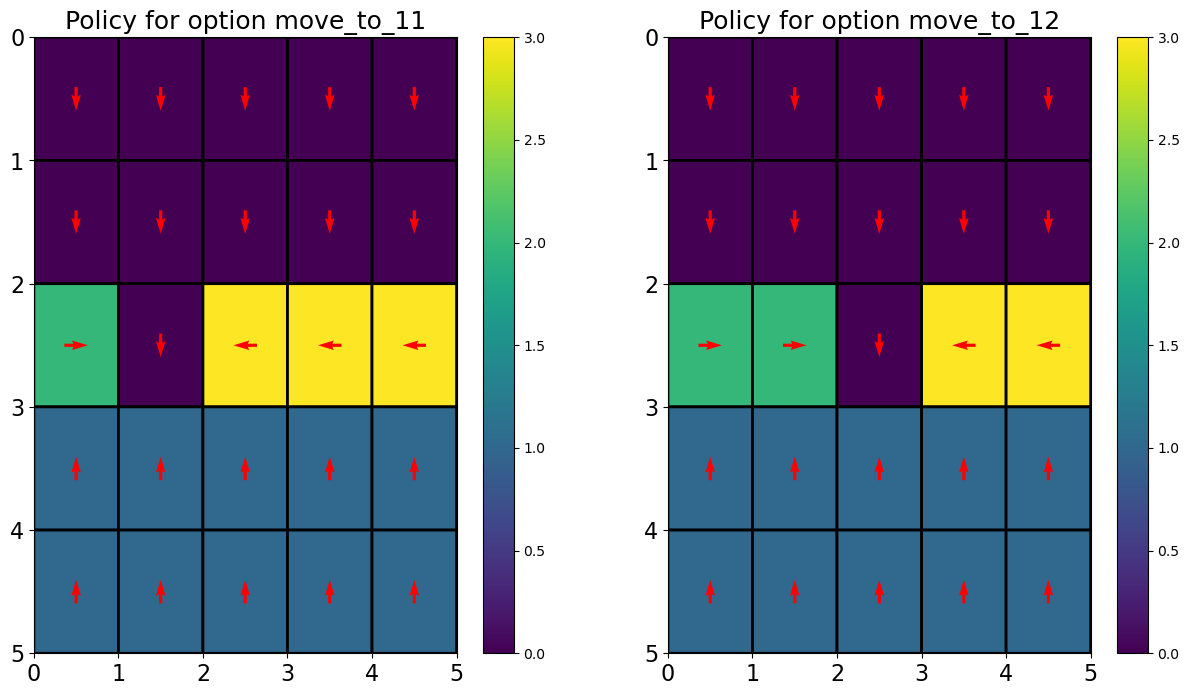

In [6]:
Options_list = ["move_to_11","move_to_12"]
plt.figure(figsize=[15,8])
for i in range(1,3):
    plt.subplot(1,2,i)
    plot_policy(Options_Policy[i-1],message="Policy for option {}".format(Options_list[i-1]))

# Intra Option Q Learning

In [7]:
class Intra_Option_Q_Learning:
    def __init__(self, env, num_options=4, Options_Policy=Options_Policy, epsilon_start=0.5, epsilon_decay=0.95, epsilon_end=0.001, gamma=0.9, alpha0=0.4):
        self.env = env
        self.Q_Options = Options_Policy
        self.Destination_Coord = {0:[11//5,11%5],1:[12//5,12%5]}
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_end = epsilon_end
        self.gamma = gamma
        self.alpha0 = alpha0
        self.q_values_SMDP_Intra = np.zeros([env.nS, env.nA + num_options])
        self.update_frequency_SMDP_Intra = np.zeros([env.nS, env.nA + num_options])
        self.options_epsilon = [epsilon_start] * num_options
        self.num_options = num_options

    def egreedy_policy(self, q_values, state, epsilon):
        if np.random.rand() < self.epsilon:
            return np.random.choice(np.arange(len(q_values[state])))
        else:
            return np.argmax(q_values[state])

    def Options(self, option_num, state):
        optact = self.Q_Options[option_num][state // 5, state % 5]
        return optact

    def update_intraoption_action(self, state, action, next_state, reward):
        self.q_values_SMDP_Intra[state][action] += self.alpha0 * (reward + self.gamma * max(self.q_values_SMDP_Intra[next_state]) - self.q_values_SMDP_Intra[state][action])
        self.update_frequency_SMDP_Intra[state][action] += 1

        state_decoded = list(self.env.decode(state))
        next_state_decoded = list(self.env.decode(next_state))

        for option in range(6, 6+self.num_options):
            optaction = self.Q_Options[option - 6][state_decoded[0],state_decoded[1]]
            next_state_is_terminal = True if [next_state_decoded[0], next_state_decoded[1]] == self.Destination_Coord[option - 6] else False

            if optaction == action:
                if not next_state_is_terminal:
                    self.q_values_SMDP_Intra[state][option] += self.alpha0 * (reward + self.gamma * self.q_values_SMDP_Intra[next_state][option] - self.q_values_SMDP_Intra[state][option])
                else:
                    self.q_values_SMDP_Intra[state][option] += self.alpha0 * (reward + self.gamma * max(self.q_values_SMDP_Intra[next_state]) - self.q_values_SMDP_Intra[state][option])
                self.update_frequency_SMDP_Intra[state][option] += 1

    def learn(self, num_epochs):
        Total_Rewards = []
        for epoch in tqdm(range(num_epochs)):
            state = self.env.reset()
            done = False
            episode_reward = 0

            while not done:
                action = self.egreedy_policy(self.q_values_SMDP_Intra, state, epsilon=self.epsilon)
                self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

                if action < self.env.nA:
                    next_state, reward, done, _ = self.env.step(action)
                    episode_reward += reward
                    self.update_intraoption_action(state, action, next_state, reward)
                    state = next_state

                if action >= self.env.nA:
                    option_num = action - self.env.nA
                    start_state = np.copy(state)
                    start_state_decoded = list(self.env.decode(start_state))
                    state_in_option = start_state_decoded[0] * 5 + start_state_decoded[1]
                    optdone = False

                    while not optdone:
                        #print(1)
                        optact = self.Options(option_num, state_in_option)
                        next_state, reward, done, _ = self.env.step(optact)
                        next_state_decoded = list(self.env.decode(next_state))
                        next_state_in_option = next_state_decoded[0] * 5 + next_state_decoded[1]
                        next_state_coord = [next_state_decoded[0], next_state_decoded[1]]
                        episode_reward += reward
                        self.update_intraoption_action(state, optact, next_state, reward)
                        state_in_option = next_state_in_option
                        state = (state_in_option * 5 + start_state_decoded[2]) * 4 + start_state_decoded[3]
                        if next_state_coord == self.Destination_Coord[option_num]:
                            optdone = True

            Total_Rewards.append(episode_reward)
        return Total_Rewards, self.q_values_SMDP_Intra, self.update_frequency_SMDP_Intra, self.Q_Options
    def test(self,num_of_runs=100):
        Total_Rewards = []
        Total_Steps = []
        for epoch in tqdm(range(num_of_runs)):
            #print(epoch)
            state = self.env.reset()    
            done = False
            episode_reward = 0
            episode_steps = 0

            # While episode is not over
            while not done:
                # Choose action        
                action = np.argmax(self.q_values_SMDP_Intra[state])

                # Checking if primitive action
                if action < self.env.nA:
                    # Perform regular Q-Learning update for state-action pair
                    state_next, reward, done, _ = self.env.step(action)
                    episode_reward+=reward
                    episode_steps+=1
                    state = state_next
                # Checking if action chosen is an option
                if action >= self.env.nA: # action 
                    option_num = action-self.env.nA
                    start_state = np.copy(state)
                    start_state_decoded = list(self.env.decode(start_state))
                    state_in_option = start_state_decoded[0]*5+start_state_decoded[1]
                    optdone = False
                    while (optdone == False):
                        #print(step)
                        #print(option_num,state_in_option)
                        optact = self.Options(option_num,state_in_option) 
                        next_state, reward, done,_ = self.env.step(optact)
                        next_state_decoded = list(self.env.decode(next_state))
                        next_state_in_option =next_state_decoded[0]*5+next_state_decoded[1]
                        next_state_coord = [next_state_decoded[0],next_state_decoded[1]]

                        if(next_state_coord==self.Destination_Coord[option_num]):
                            optdone = True

                        # Is this formulation right? What is this term?
                        # The Formulaion is not correct because later states should be discounted more
                        episode_reward+=reward
                        episode_steps+=1
                        state_in_option = next_state_in_option
                        
                    state = (state_in_option*5 + start_state_decoded[2]) * 4 + start_state_decoded[3]
            Total_Rewards.append(episode_reward)
            Total_Steps.append(episode_steps)
        return Total_Rewards,Total_Steps

In [8]:
ioql = Intra_Option_Q_Learning(env,num_options=2,Options_Policy=Options_Policy,epsilon_start=1,epsilon_decay=0.9,epsilon_end=0.001,gamma=0.9,alpha0=0.4)
Total_Rewards_Intra,Q_Values_SMDP_Intra,Update_Frequency_SMDP_Intra,Q_Options_Intra = ioql.learn(num_epochs=10000)
Total_Test_Rewards,Total_Test_Steps = ioql.test(num_of_runs=1000)
print("Avg_Test_Rewards = {}\nAvg_Test_Steps = {}\n".format(np.mean(Total_Test_Rewards),np.mean(Total_Test_Steps)))

100%|██████████| 1000/1000 [00:00<00:00, 4510.69it/s]

Avg_Test_Rewards = 7.944
Avg_Test_Steps = 13.056



# WandB

In [9]:
import wandb
wandb.login(key = "8545e71f98dc96fbac53295facb12404fc77016d")

wandb: Currently logged in as: nayinisriharsh-iitm. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\nayin\.netrc


True

In [10]:
def train_and_tune(config=None):
  # Initialize a new wandb run
  with wandb.init(config=config):
    # If called by wandb.agent, as below,
    # this config will be set by Sweep Controller
    config = wandb.config
    wandb.run.name='eps'+str(config.epsilon_start)+'-epd'+str(config.epsilon_decay)+'-epe'+str(config.epsilon_end)+'-gm'+str(config.gamma)+'alp'+str(config.alpha0)
    env = gym.make('Taxi-v3')
    ioql = Intra_Option_Q_Learning(env,num_options=2,Options_Policy=Options_Policy,epsilon_start=config.epsilon_start,epsilon_decay=config.epsilon_decay,epsilon_end=config.epsilon_end,gamma=config.gamma,alpha0=config.alpha0)
    Total_Rewards,Q_Values_SMDP,Update_Frequency_SMDP,Q_Options_SMDP = ioql.learn(num_epochs=10000)
    Total_Test_Rewards,Total_Test_Steps = ioql.test(num_of_runs=1000)
    #wandb.log({"train_mean_reward":rewards,"train_mean_steps":steps,"test_mean_reward":r,"train_mean_steps":s})
    #data = [[x, y] for (x, y) in zip(np.arange(config.episodes), rewards)]
    #table1 = wandb.Table(data=data, columns=["x", "y"])
    #data = [[x, y] for (x, y) in zip(np.arange(config.episodes), steps)]
    #table2 = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            "avg_reward":np.mean(Total_Test_Rewards),'avg_steps':np.mean(Total_Test_Steps) #,"train_reward": wandb.plot.line(table1, "x", "y", title="Reward vs Episode"),"train_steps": wandb.plot.line(table2, "x", "y", title="Steps vs Episode"),
        }
    )

In [11]:
sweep_config={'method':'bayes',
              'metric' : {
                  'name':'avg_reward',
                  'goal':'maximize'},
              'parameters':{
                  'epsilon_start':{'values':[0.5,1]},
                  'epsilon_decay':{'values':[0.95,0.9,0.85]},
                  'epsilon_end' :{'values':[0.001,0.0001]},
                  'gamma' : {'values':[0.99,0.95,0.9,0.85]},
                  'alpha0': {'values':[0.3,0.4,0.5]}
                  }}
import pprint
pprint.pprint(sweep_config)
sweep_id=wandb.sweep(sweep_config,project="CS6700_PROGRAMMING_ASSIGNMENT_3")

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'avg_reward'},
 'parameters': {'alpha0': {'values': [0.3, 0.4, 0.5]},
                'epsilon_decay': {'values': [0.95, 0.9, 0.85]},
                'epsilon_end': {'values': [0.001, 0.0001]},
                'epsilon_start': {'values': [0.5, 1]},
                'gamma': {'values': [0.99, 0.95, 0.9, 0.85]}}}
Create sweep with ID: iivnt4nc
Sweep URL: https://wandb.ai/nayinisriharsh-iitm/CS6700_PROGRAMMING_ASSIGNMENT_3/sweeps/iivnt4nc


In [ ]:
wandb.agent(sweep_id,train_and_tune,count=40)

wandb: Agent Starting Run: f1dfrdeh with config:
wandb: 	alpha0: 0.3
wandb: 	epsilon_decay: 0.85
wandb: 	epsilon_end: 0.0001
wandb: 	epsilon_start: 1
wandb: 	gamma: 0.99


100%|██████████| 1000/1000 [00:00<00:00, 5596.02it/s]


avg_reward,▁
avg_steps,▁
avg_reward,8.003
avg_steps,12.997


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d2n1vjmt with config:
wandb: 	alpha0: 0.3
wandb: 	epsilon_decay: 0.9
wandb: 	epsilon_end: 0.0001
wandb: 	epsilon_start: 0.5
wandb: 	gamma: 0.99


100%|██████████| 1000/1000 [00:00<00:00, 5554.32it/s]


avg_reward,▁
avg_steps,▁
avg_reward,7.79
avg_steps,13.21
